# 2. Làm sạch và chuẩn hóa dữ liệu

Trong notebook này, chúng ta sẽ thực hiện các bước làm sạch và chuẩn hóa dữ liệu để chuẩn bị cho việc xây dựng mô hình phân loại bài viết thành Khoa học hoặc Công nghệ.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from wordcloud import WordCloud

# Thiết lập để hiển thị biểu đồ đẹp hơn
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Để hiển thị Tiếng Việt đúng
plt.rcParams['font.family'] = 'DejaVu Sans'

# Tạo thư mục nếu chưa tồn tại
os.makedirs('../clean_data', exist_ok=True)

import warnings
warnings.filterwarnings('ignore')

In [24]:
# Đọc dữ liệu từ thư mục raw_data
df_clean = pd.read_csv('../raw_data/vnexpress_raw_data.csv', encoding='utf-8')
print(f"Số lượng bản ghi: {len(df_clean)}")
print(f"Số lượng cột: {len(df_clean.columns)}")

Số lượng bản ghi: 1184
Số lượng cột: 11


## 2.1. Xử lý dữ liệu thiếu

Đầu tiên, chúng ta sẽ kiểm tra và xử lý các giá trị bị thiếu trong tập dữ liệu.

In [25]:
# Hiển thị số lượng giá trị thiếu trước khi xử lý
print("Số lượng giá trị thiếu trước khi xử lý:")
missing_before = df_clean.isnull().sum()
missing_percentage_before = (df_clean.isnull().sum() / len(df_clean) * 100).round(2)
pd.DataFrame({
    'Giá Trị Thiếu': missing_before,
    'Phần Trăm (%)': missing_percentage_before
})

Số lượng giá trị thiếu trước khi xử lý:


,Giá Trị Thiếu,Phần Trăm (%)
title,0,0.00
description,2,0.17
date,2,0.17
category,56,4.73
thumbnail,41,3.46
content,3,0.25
author,252,21.28
tags,0,0.00
group,0,0.00
nums_of_comments,0,0.00


### 2.1.1. Chiến lược xử lý dữ liệu thiếu

- Đối với các trường văn bản (title, description, content): điền bằng chuỗi rỗng
- Đối với trường category: điền bằng "Khác"
- Đối với trường thumbnail: điền bằng "No Image"
- Đối với trường author: điền bằng "Không xác định"
- Đối với bản ghi thiếu date: loại bỏ khỏi tập dữ liệu vì date là trường quan trọng để phân tích xu hướng

In [26]:
df_clean.fillna({
    'description': '',
    'category': 'Khác',
    'thumbnail': 'No Image',
    'author': 'Không xác định',
    'content': '',
}, inplace=True)

# drop date column null
df_clean.dropna(subset=['date'], inplace=True)

# Kiểm tra lại sau khi điền giá trị thiếu
print("Số lượng giá trị thiếu sau khi xử lý:")
missing_after = df_clean.isnull().sum()
missing_percentage_after = (df_clean.isnull().sum() / len(df_clean) * 100).round(2)
pd.DataFrame({
    'Giá Trị Thiếu': missing_after,
    'Phần Trăm (%)': missing_percentage_after
})

Số lượng giá trị thiếu sau khi xử lý:


,Giá Trị Thiếu,Phần Trăm (%)
title,0,0.0
description,0,0.0
date,0,0.0
category,0,0.0
thumbnail,0,0.0
content,0,0.0
author,0,0.0
tags,0,0.0
group,0,0.0
nums_of_comments,0,0.0


## 2.2. Làm sạch dữ liệu văn bản

Dữ liệu văn bản cần được làm sạch để loại bỏ các HTML tags, URL, ký tự đặc biệt và chuẩn hóa khoảng trắng.

In [27]:
def clean_text(text):
    if pd.isna(text):
        return ""
        
    # Loại bỏ HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Loại bỏ URL
    text = re.sub(r'http\S+', ' ', text)
    # Loại bỏ ký tự đặc biệt và số
    text = re.sub(r'[^\w\s]', ' ', text)
    # Loại bỏ khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

# Áp dụng hàm làm sạch cho các cột văn bản
df_clean['content_cleaned'] = df_clean['content'].apply(clean_text)
df_clean['description_cleaned'] = df_clean['description'].apply(clean_text)
df_clean['title_cleaned'] = df_clean['title'].apply(clean_text)

# Kiểm tra độ dài của các cột văn bản trước và sau khi làm sạch
df_clean['content_length'] = df_clean['content'].apply(len)
df_clean['description_length'] = df_clean['description'].apply(len)
df_clean['title_length'] = df_clean['title'].apply(len)

# Tính độ dài sau khi làm sạch
df_clean['content_cleaned_length'] = df_clean['content_cleaned'].apply(len)
df_clean['description_cleaned_length'] = df_clean['description_cleaned'].apply(len)
df_clean['title_cleaned_length'] = df_clean['title_cleaned'].apply(len)

### 2.2.1. So sánh dữ liệu trước và sau khi làm sạch

Chúng ta sẽ so sánh độ dài dữ liệu trước và sau khi làm sạch để đánh giá hiệu quả của quá trình xử lý.

In [28]:
# So sánh độ dài trước và sau khi làm sạch
comparison = pd.DataFrame({
    'Tiêu đề (Trước)': df_clean['title_length'].describe(),
    'Tiêu đề (Sau)': df_clean['title_cleaned_length'].describe(),
    'Mô tả (Trước)': df_clean['description_length'].describe(),
    'Mô tả (Sau)': df_clean['description_cleaned_length'].describe(),
    'Nội dung (Trước)': df_clean['content_length'].describe(),
    'Nội dung (Sau)': df_clean['content_cleaned_length'].describe()
}).round(2)

comparison

,Tiêu đề (Trước),Tiêu đề (Sau),Mô tả (Trước),Mô tả (Sau),Nội dung (Trước),Nội dung (Sau)
count,1182.00,1182.00,1182.00,1182.00,1182.00,1182.00
mean,49.48,48.94,138.93,136.27,2938.12,2860.14
std,10.32,10.18,22.65,22.33,1824.72,1774.09
min,17.00,17.00,78.00,75.00,0.00,0.00
25%,42.00,42.00,124.00,122.00,1953.25,1894.25
50%,50.00,49.50,137.00,134.00,2593.50,2519.00
75%,56.00,56.00,151.00,147.75,3585.25,3491.75
max,79.00,79.00,224.00,221.00,12664.00,12269.00


### 2.2.2. Trực quan hóa sự thay đổi của dữ liệu sau khi làm sạch

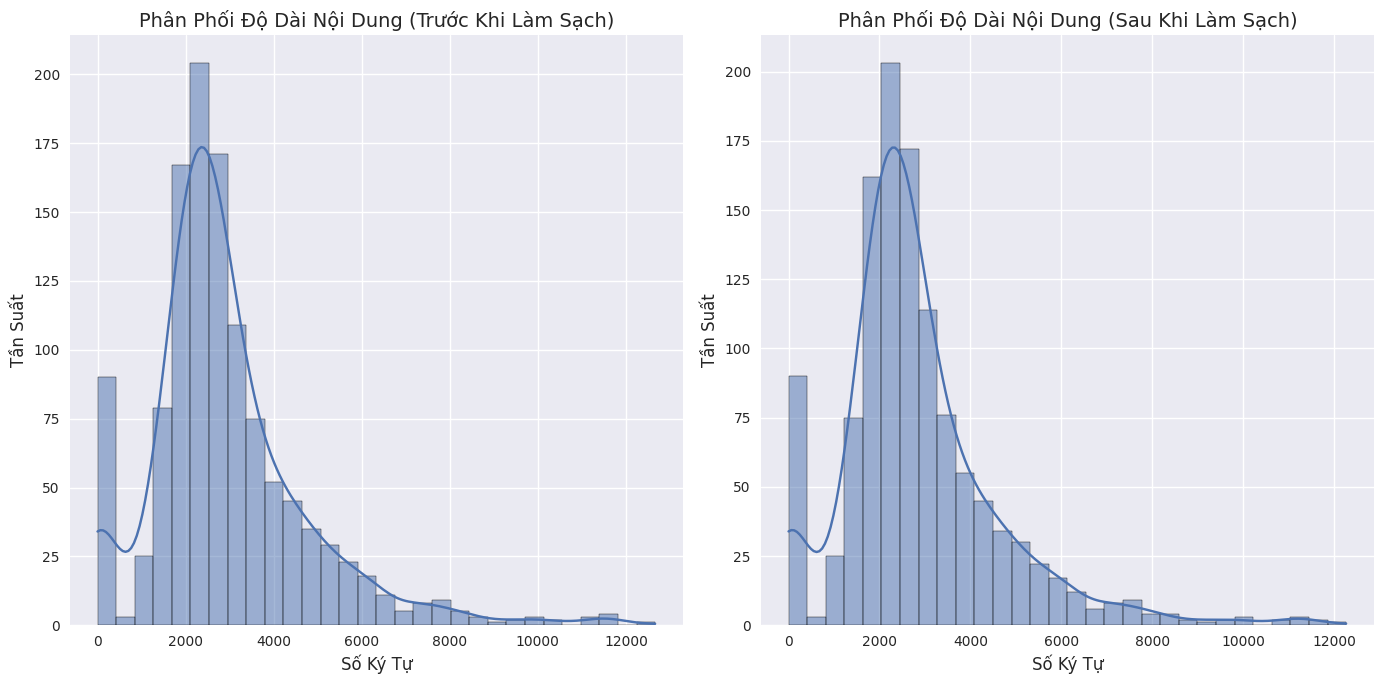

In [29]:
# Trực quan hóa sự thay đổi trước và sau khi làm sạch cho độ dài nội dung
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.histplot(data=df_clean['content_length'], kde=True, bins=30)
plt.title('Phân Phối Độ Dài Nội Dung (Trước Khi Làm Sạch)', fontsize=14)
plt.xlabel('Số Ký Tự', fontsize=12)
plt.ylabel('Tần Suất', fontsize=12)

plt.subplot(1, 2, 2)
sns.histplot(data=df_clean['content_cleaned_length'], kde=True, bins=30)
plt.title('Phân Phối Độ Dài Nội Dung (Sau Khi Làm Sạch)', fontsize=14)
plt.xlabel('Số Ký Tự', fontsize=12)
plt.ylabel('Tần Suất', fontsize=12)

plt.tight_layout()
plt.show()

## 2.3. Chuyển đổi kiểu dữ liệu và chuẩn hóa
### 2.3.1. Xử lý tags và chuẩn hóa tác giả

In [30]:
# Xử lý cột tags
df_clean['tags_list'] =  df_clean['tags'].str.split(',').apply(lambda x: [tag.strip() for tag in x])
df_clean['tags_count'] = df_clean['tags_list'].apply(len)

print("Số lượng tags trung bình mỗi bài viết:", df_clean['tags_count'].mean())
print("Số lượng tác giả trước khi làm sạch:", df_clean['author'].nunique())
# Xử lý cột author (loại bỏ phần trong ngoặc)
df_clean['author_cleaned'] = df_clean['author'].apply(lambda x: re.sub(r'\s*\(.*?\)', '', str(x)).strip())
# loại bỏ các ký tự không cần thiết 
df_clean['author_cleaned'] = df_clean['author_cleaned'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)).strip())

df_clean['content_cleaned'] = df_clean['content_cleaned'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)).strip())

print("Số lượng tags trung bình mỗi bài viết:", df_clean['tags_count'].mean())
print("Số lượng tác giả khác nhau sau khi làm sạch:", df_clean['author_cleaned'].nunique())

Số lượng tags trung bình mỗi bài viết: 3.8790186125211505
Số lượng tác giả trước khi làm sạch: 307
Số lượng tags trung bình mỗi bài viết: 3.8790186125211505
Số lượng tác giả khác nhau sau khi làm sạch: 151


### 2.3.2. Trực quan hóa các tags phổ biến

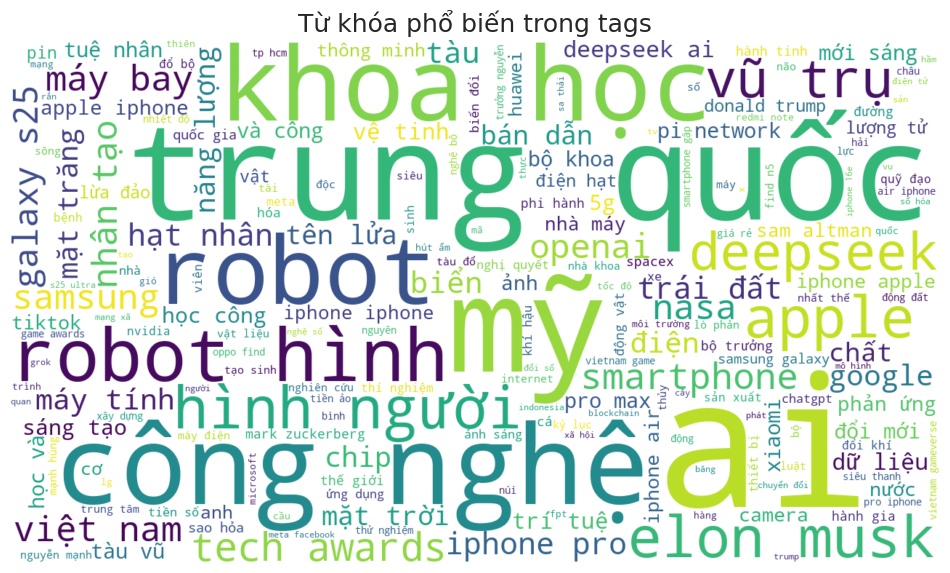

In [31]:

all_tags = ', '.join([', '.join(tags) for tags in df_clean['tags_list']])
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=1280, height=720, background_color='white', max_words=200, contour_width=3).generate(all_tags)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Từ khóa phổ biến trong tags', fontsize=18)
plt.show()

### 2.3.3. Trực quan hóa các tác giả phổ biến

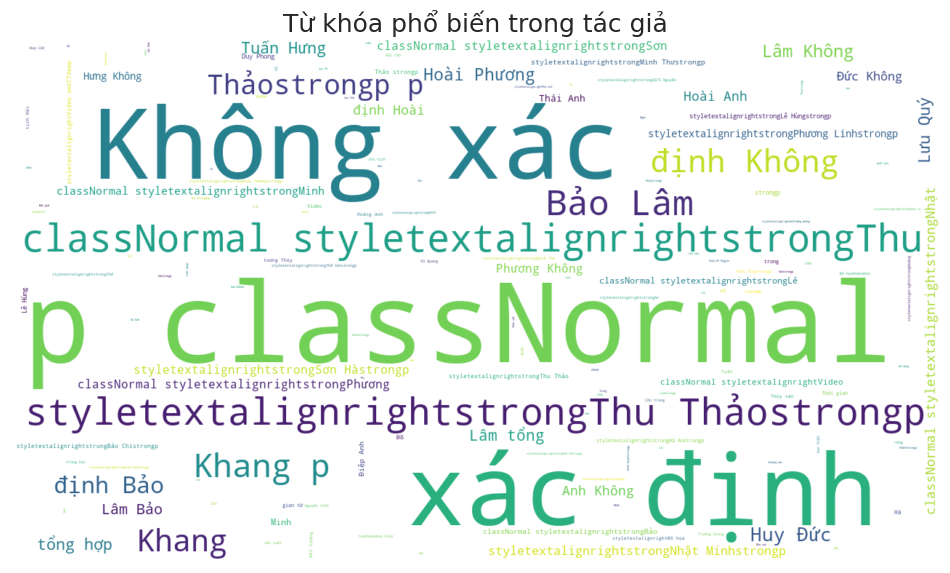

In [32]:
all_tags = ', '.join(df_clean['author_cleaned'].astype(str).tolist())
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=1280, height=720, background_color='white', max_words=200, contour_width=3).generate(all_tags)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Từ khóa phổ biến trong tác giả', fontsize=18)
plt.show()

## 2.4. Chuẩn hóa dữ liệu thời gian
Chuyển đổi cột date sang định dạng datetime và trích xuất thông tin như năm, tháng, ngày, giờ và ngày trong tuần.

In [33]:
# Chuẩn hóa cột ngày tháng
df_clean['date_clean'] = df_clean['date'].str.split(', ', n=1).str[1]
df_clean['date'] = pd.to_datetime(df_clean['date_clean'], format='%d/%m/%Y, %H:%M (GMT+7)', errors='coerce')

# Tạo các đặc trưng thời gian
df_clean['year'] = df_clean['date'].dt.year
df_clean['month'] = df_clean['date'].dt.month
df_clean['day'] = df_clean['date'].dt.day
df_clean['hour'] = df_clean['date'].dt.hour
df_clean['day_of_week'] = df_clean['date'].dt.dayofweek  # 0 là Monday, 6 là Sunday

# Kiểm tra giá trị null sau khi chuyển đổi
print(f"Số lượng giá trị ngày tháng hợp lệ: {df_clean['date'].notnull().sum()} ({df_clean['date'].notnull().sum()/len(df_clean)*100:.2f}%)")
print(f"Số lượng giá trị ngày tháng không hợp lệ: {df_clean['date'].isnull().sum()} ({df_clean['date'].isnull().sum()/len(df_clean)*100:.2f}%)")

Số lượng giá trị ngày tháng hợp lệ: 1182 (100.00%)
Số lượng giá trị ngày tháng không hợp lệ: 0 (0.00%)


### 2.4.1. Phân bố bài viết theo thời gian

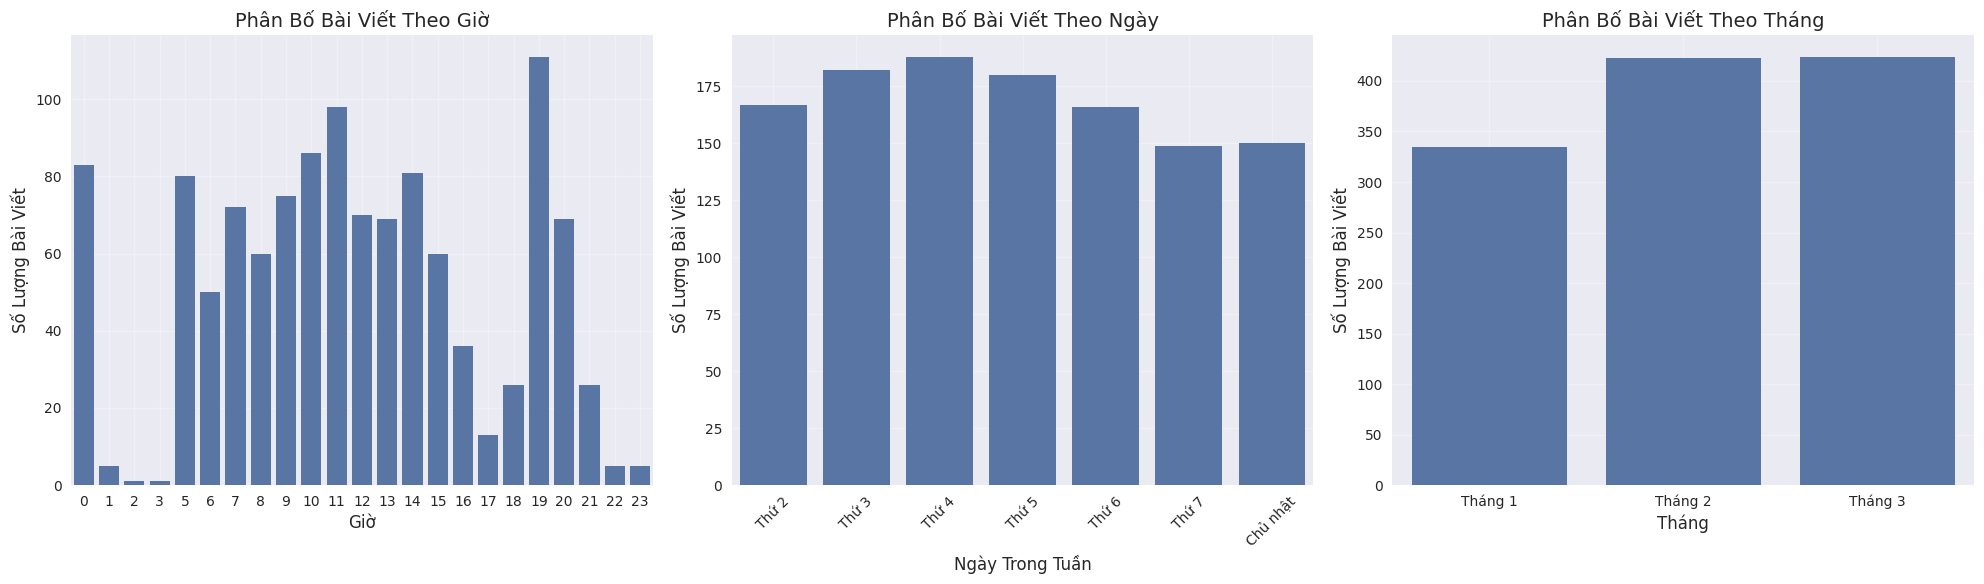

In [34]:
# Tạo figure với 3 subplot nằm ngang
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Biểu đồ phân bố theo giờ trong ngày
hour_counts = df_clean['hour'].value_counts().sort_index()
sns.barplot(x=hour_counts.index, y=hour_counts.values, ax=axes[0])
axes[0].set_title('Phân Bố Bài Viết Theo Giờ', fontsize=14)
axes[0].set_xlabel('Giờ', fontsize=12)
axes[0].set_ylabel('Số Lượng Bài Viết', fontsize=12)
axes[0].set_xticks(range(len(hour_counts)))
axes[0].set_xticklabels([f'{h}' for h in hour_counts.index])
axes[0].grid(True, alpha=0.3)

# 2. Biểu đồ phân bố theo ngày trong tuần
days = ['Thứ 2', 'Thứ 3', 'Thứ 4', 'Thứ 5', 'Thứ 6', 'Thứ 7', 'Chủ nhật']
day_counts = df_clean['day_of_week'].value_counts().sort_index()
sns.barplot(x=day_counts.index, y=day_counts.values, ax=axes[1])
axes[1].set_title('Phân Bố Bài Viết Theo Ngày', fontsize=14)
axes[1].set_xlabel('Ngày Trong Tuần', fontsize=12)
axes[1].set_ylabel('Số Lượng Bài Viết', fontsize=12)
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(days, rotation=45)
axes[1].grid(True, alpha=0.3)

# 3. Biểu đồ phân bố theo tháng
month_counts = df_clean['month'].value_counts().sort_index()
sns.barplot(x=month_counts.index, y=month_counts.values, ax=axes[2])
axes[2].set_title('Phân Bố Bài Viết Theo Tháng', fontsize=14)
axes[2].set_xlabel('Tháng', fontsize=12)
axes[2].set_ylabel('Số Lượng Bài Viết', fontsize=12)
axes[2].set_xticks(range(len(month_counts)))
axes[2].set_xticklabels([f'Tháng {m}' for m in month_counts.index])
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2.4.2. Phân bố bình luận theo thời gian

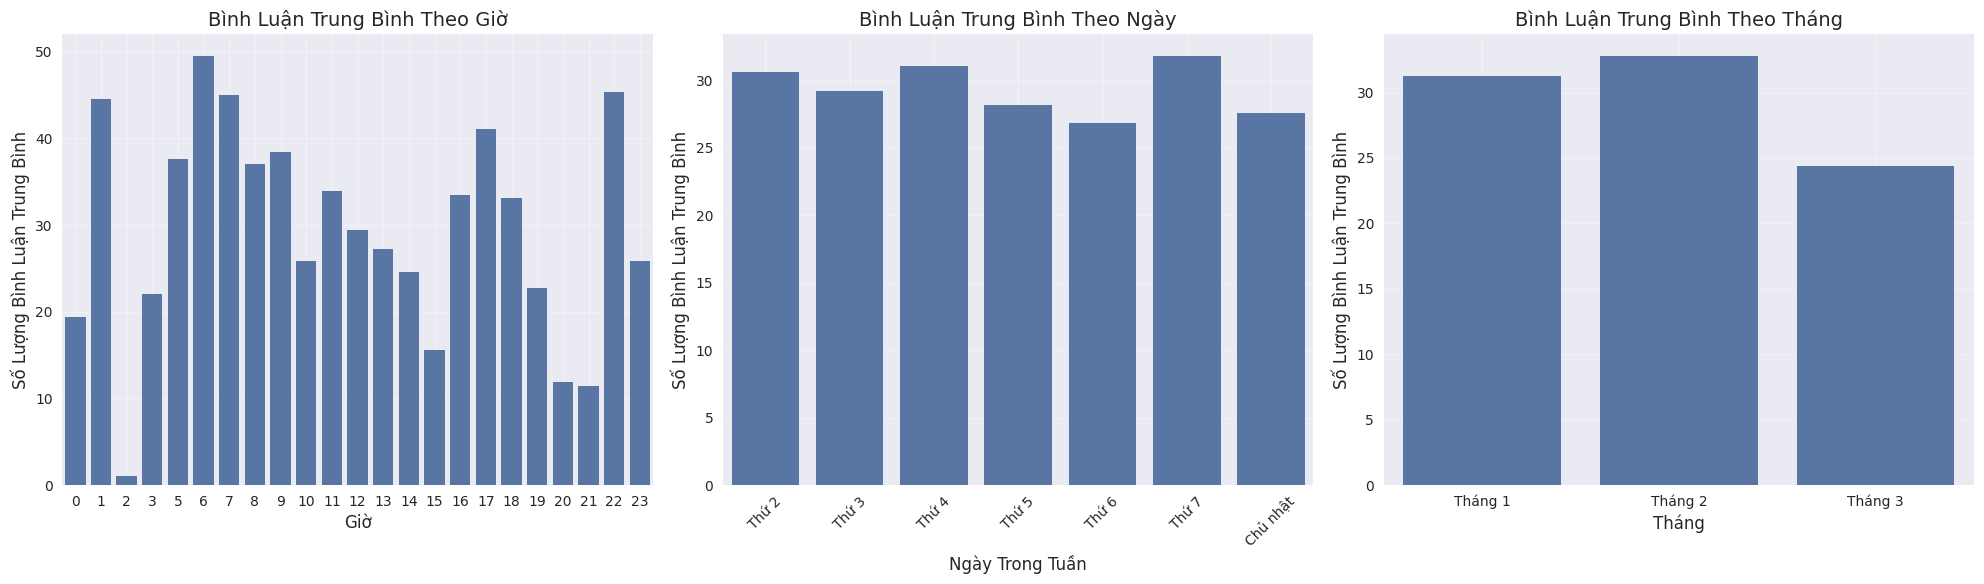

In [35]:
# Tạo biểu đồ phân bố bình luận trung bình theo giờ, ngày và tháng
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Biểu đồ phân bố bình luận trung bình theo giờ
comments_by_hour = df_clean.groupby('hour')['nums_of_comments'].mean().sort_index()
sns.barplot(x=comments_by_hour.index, y=comments_by_hour.values, ax=axes[0])
axes[0].set_title('Bình Luận Trung Bình Theo Giờ', fontsize=14)
axes[0].set_xlabel('Giờ', fontsize=12)
axes[0].set_ylabel('Số Lượng Bình Luận Trung Bình', fontsize=12)
axes[0].set_xticks(range(len(comments_by_hour)))
axes[0].set_xticklabels([f'{h}' for h in comments_by_hour.index])
axes[0].grid(True, alpha=0.3)

# 2. Biểu đồ phân bố bình luận theo ngày trong tuần
comments_by_day = df_clean.groupby('day_of_week')['nums_of_comments'].mean().sort_index()
days = ['Thứ 2', 'Thứ 3', 'Thứ 4', 'Thứ 5', 'Thứ 6', 'Thứ 7', 'Chủ nhật']
sns.barplot(x=comments_by_day.index, y=comments_by_day.values, ax=axes[1])
axes[1].set_title('Bình Luận Trung Bình Theo Ngày', fontsize=14)
axes[1].set_xlabel('Ngày Trong Tuần', fontsize=12)
axes[1].set_ylabel('Số Lượng Bình Luận Trung Bình', fontsize=12)
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(days, rotation=45)
axes[1].grid(True, alpha=0.3)

# 3. Biểu đồ phân bố bình luận theo tháng
comments_by_month = df_clean.groupby('month')['nums_of_comments'].mean().sort_index()
sns.barplot(x=comments_by_month.index, y=comments_by_month.values, ax=axes[2])
axes[2].set_title('Bình Luận Trung Bình Theo Tháng', fontsize=14)
axes[2].set_xlabel('Tháng', fontsize=12)
axes[2].set_ylabel('Số Lượng Bình Luận Trung Bình', fontsize=12)
axes[2].set_xticks(range(len(comments_by_month)))
axes[2].set_xticklabels([f'Tháng {m}' for m in comments_by_month.index])
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 2.6. Tổng hợp và xuất dữ liệu đã làm sạch
Sau khi thực hiện tất cả các bước làm sạch và chuẩn hóa, chúng ta sẽ tạo một tập dữ liệu cuối cùng và lưu nó vào thư mục clean_data.

In [36]:
# Chọn các cột quan trọng cho bài toán phân loại
cols_final = ['title_cleaned_length', 'description_cleaned_length', 'content_cleaned_length', 'content_cleaned', 
              'title_cleaned', 'description_cleaned', 'tags_count', 'tags_list', 'category', 'nums_of_comments', 
              'hour', 'day_of_week', 'month', 'year', 'author_cleaned', 'group']

# Thêm 'group' vào danh sách cột - đây là biến mục tiêu cho bài toán phân loại
df_clean_final = df_clean[cols_final].copy()

# Copy lại các cột để dễ dàng truy cập
df_clean_final['nums_of_comments'] = df_clean_final['nums_of_comments']
df_clean_final['tags_count'] = df_clean_final['tags_count']
df_clean_final['hour'] = df_clean_final['hour']
df_clean_final['day_of_week'] = df_clean_final['day_of_week']
df_clean_final['month'] = df_clean_final['month']
df_clean_final['year'] = df_clean_final['year']
df_clean_final['category'] = df_clean_final['category']
df_clean_final['author'] = df_clean_final['author_cleaned']
df_clean_final['tags_list'] = df_clean_final['tags_list']
df_clean_final['content'] = df_clean_final['content_cleaned']
df_clean_final['title'] = df_clean_final['title_cleaned']
df_clean_final['description'] = df_clean_final['description_cleaned']
df_clean_final['content_length'] = df_clean_final['content_cleaned_length']
df_clean_final['title_length'] = df_clean_final['title_cleaned_length']
df_clean_final['description_length'] = df_clean_final['description_cleaned_length']

# Lưu dữ liệu đã làm sạch
df_clean_final.to_csv('../clean_data/vnexpress_clean_data.csv', index=False, encoding='utf-8-sig')
print(f"Đã lưu dữ liệu đã làm sạch với {len(df_clean_final)} bản ghi và {len(df_clean_final.columns)} cột.")

Đã lưu dữ liệu đã làm sạch với 1182 bản ghi và 23 cột.


In [37]:
# Hiển thị thông tin cơ bản của tập dữ liệu đã làm sạch
df_clean_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1182 entries, 0 to 1183
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   title_cleaned_length        1182 non-null   int64 
 1   description_cleaned_length  1182 non-null   int64 
 2   content_cleaned_length      1182 non-null   int64 
 3   content_cleaned             1182 non-null   object
 4   title_cleaned               1182 non-null   object
 5   description_cleaned         1182 non-null   object
 6   tags_count                  1182 non-null   int64 
 7   tags_list                   1182 non-null   object
 8   category                    1182 non-null   object
 9   nums_of_comments            1182 non-null   int64 
 10  hour                        1182 non-null   int32 
 11  day_of_week                 1182 non-null   int32 
 12  month                       1182 non-null   int32 
 13  year                        1182 non-null   int32 
 1

In [38]:
df_clean_final['group']

0       Công nghệ
1       Công nghệ
2       Công nghệ
3       Công nghệ
4       Công nghệ
          ...    
1179     Khoa học
1180     Khoa học
1181     Khoa học
1182     Khoa học
1183     Khoa học
Name: group, Length: 1182, dtype: object

In [39]:
df_clean_final.head(5)

,title_cleaned_length,description_cleaned_length,content_cleaned_length,content_cleaned,title_cleaned,description_cleaned,tags_count,tags_list,category,nums_of_comments,...,year,author_cleaned,group,author,content,title,description,content_length,title_length,description_length
0,48,115,4011,Trong livestream ra mắt Grok 3 trên X diễn ra ...,Elon Musk ra chatbot AI thông minh nhất Trái Đất,xAI công ty do Elon Musk sáng lập công bố Grok...,1,[elon musk],AI,118,...,2025,Bảo Lâm,Công nghệ,Bảo Lâm,Trong livestream ra mắt Grok 3 trên X diễn ra ...,Elon Musk ra chatbot AI thông minh nhất Trái Đất,xAI công ty do Elon Musk sáng lập công bố Grok...,4011,48,115
1,62,130,1427,So với các củ sạc laptop công suất 70W của các...,Winsler 70W Ultra Slim củ sạc laptop mỏng nhẹ ...,Củ sạc Winsler 70W có độ mỏng 12 8 mm tích hợp...,2,"[winsler, sạc laptop]",Thiết bị,0,...,2025,Không xác định,Công nghệ,Không xác định,So với các củ sạc laptop công suất 70W của các...,Winsler 70W Ultra Slim củ sạc laptop mỏng nhẹ ...,Củ sạc Winsler 70W có độ mỏng 12 8 mm tích hợp...,1427,62,130
2,37,142,1342,Cuối tháng 1 chuyên gia tin đồn Majin Bu đăngb...,Kiểu dáng của iPhone 17 Air siêu mỏng,Dựa trên hình ảnh và thông tin rò rỉ iPhone 17...,3,"[iphone 17 air, iphone 17, chân dung iphone 17...",Thiết bị,41,...,2025,Không xác định,Công nghệ,Không xác định,Cuối tháng 1 chuyên gia tin đồn Majin Bu đăngb...,Kiểu dáng của iPhone 17 Air siêu mỏng,Dựa trên hình ảnh và thông tin rò rỉ iPhone 17...,1342,37,142
3,22,130,2613,Ngày 12 3 Intel thông báo việc bổ nhiệm Lip Bu...,Intel tìm được CEO mới,Intel hiện bổ nhiệm Lip Bu Tan doanh nhân gốc ...,3,"[intel, ceo intel, lip-bu tan]",Nhân vật,30,...,2025,CEO Intel Pat Gelsinger Ảnh Intel,Công nghệ,CEO Intel Pat Gelsinger Ảnh Intel,Ngày 12 3 Intel thông báo việc bổ nhiệm Lip Bu...,Intel tìm được CEO mới,Intel hiện bổ nhiệm Lip Bu Tan doanh nhân gốc ...,2613,22,130
4,48,103,3749,Trong video đăng trên RedNote Xiaohongshu tuần...,Chi 1 400 USD thuê robot hình người làm việc nhà,Trung QuốcZhang Genyuan 25 tuổi thuê robot hìn...,2,"[robot hình người, trung quốc]",Nhịp sống số,37,...,2025,Bảo Lâm tổng hợp,Công nghệ,Bảo Lâm tổng hợp,Trong video đăng trên RedNote Xiaohongshu tuần...,Chi 1 400 USD thuê robot hình người làm việc nhà,Trung QuốcZhang Genyuan 25 tuổi thuê robot hìn...,3749,48,103


## 2.7. Kết luận

Trong notebook này, chúng ta đã thực hiện các bước làm sạch và chuẩn hóa dữ liệu bao gồm:

1. Xử lý dữ liệu thiếu cho các trường quan trọng
2. Làm sạch dữ liệu văn bản bằng cách loại bỏ HTML, URL, ký tự đặc biệt
3. Chuyển đổi kiểu dữ liệu và chuẩn hóa tags, tác giả
4. Chuẩn hóa dữ liệu thời gian và trích xuất các đặc trưng từ thời gian
5. Phát hiện và xử lý outlier

Dữ liệu đã được làm sạch và lưu vào thư mục `clean_data` để sử dụng cho các bước tiếp theo trong quá trình phân tích.